In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Custom Data Loader

In [2]:
import pandas as pd
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torchvision.utils as vutils

In [25]:
class CustomDataLoader(Dataset):
    def __init__(self, data_dir, csv_file, image_format='.jpg', transform=None, has_subfolders=True):
        self.data_dir = Path(data_dir)
        self.labels_df = pd.read_csv(csv_file)

        # Adjust img_name padding and format based on file names
        self.labels_df['img_name'] = self.labels_df['img_name'].apply(lambda x: f"{int(x):08d}{image_format}")

        # Modify path construction based on whether the dataset has subfolders for each class
        if has_subfolders:
            self.labels_df['image_path'] = self.labels_df.apply(
                lambda row: self.data_dir / row['vclass'] / row['img_name'], axis=1)
        else:
            self.labels_df['image_path'] = self.labels_df.apply(
                lambda row: self.data_dir / row['img_name'], axis=1)

        # Filter for existing images
        self.labels_df = self.labels_df[self.labels_df['image_path'].apply(lambda path: path.exists())]
        print(f"Number of existing images: {len(self.labels_df)}")


        # Define transformations
        self.transform = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(p=1.0),  # Flip horizontally
            transforms.RandomVerticalFlip(p=1.0),    # Flip vertically
            transforms.ToTensor(),                    # Convert to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                                 std=[0.229, 0.224, 0.225])
        ])


        # Determine if bounding box data is available, indicating a localization task
        self.task_type = 'localization' if 'x1' in self.labels_df.columns else 'classification'
        if self.task_type == 'localization':
            self.labels_df['bbox'] = list(zip(
                self.labels_df['x1'], self.labels_df['y1'],
                self.labels_df['x2'], self.labels_df['y2']))

        self.labels_df.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        image_path = self.labels_df.iloc[idx]['image_path']
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels_df.iloc[idx]['vclass']
        sample = {'image': image, 'label': label}

        if self.task_type == 'localization':
            bbox = self.labels_df.iloc[idx]['bbox']
            sample['bbox'] = bbox

        return sample

In [26]:
# Define the path
classification_dataset = CustomDataLoader(
    data_dir='/content/drive/MyDrive/CV_ENG_8160/HW1/classification/data',
    csv_file='/content/drive/MyDrive/CV_ENG_8160/HW1/classification/train.csv',
    has_subfolders=True
)

localization_dataset = CustomDataLoader(
    data_dir='/content/drive/MyDrive/CV_ENG_8160/HW1/localize/classd',
    csv_file='/content/drive/MyDrive/CV_ENG_8160/HW1/localize/train.csv',
    has_subfolders=False
)

Number of existing images: 284
Number of existing images: 239


In [27]:
# Create DataLoaders
classification_dataloader = DataLoader(classification_dataset, batch_size=4, shuffle=True,)
localization_dataloader = DataLoader(localization_dataset, batch_size=4, shuffle=True)

In [28]:
# Test the first batch
for  batch in classification_dataloader:
    images, labels, = batch['image'], batch['label']
    print(f"Batch_sample : Images shape: {images.shape}, Labels: {labels}")
    break

for batch in localization_dataloader:
    images, labels, bboxes = batch['image'], batch['label'], batch['bbox']
    print(f"Batch_sample: Images shape: {images.shape}, Labels: {labels}, Bounding Boxes: {bboxes}")
    break

Batch_sample : Images shape: torch.Size([4, 3, 128, 128]), Labels: ['work_van', 'bicycle', 'bicycle', 'motorcycle']
Batch_sample: Images shape: torch.Size([4, 3, 128, 128]), Labels: ['car', 'car', 'car', 'car'], Bounding Boxes: [tensor([403, 317, 468, 263]), tensor([146, 197,  55,  37]), tensor([504, 397, 539, 290]), tensor([232, 245,  88,  47])]


#### Virtualization

In [29]:
def show_image_batch(data_loader, n_images=4):
    """Show images from a batch with labels."""
    # Get a single batch from the data loader
    batch = next(iter(data_loader))

    # The batch is a dictionary with 'image' and 'label' (and possibly 'bbox')
    images, labels = batch['image'], batch['label']

    # Convert to grid
    grid = vutils.make_grid(images, nrow=n_images, normalize=True)

    # Convert grid to a numpy array and transpose axes to display with matplotlib
    np_grid = grid.numpy().transpose((1, 2, 0))

    # Plot the grid of images
    fig, ax = plt.subplots(figsize=(n_images * 4, 4))
    ax.imshow(np_grid)
    ax.axis('off')

    # Calculate coordinates for labels
    for index in range(n_images):
        # Assuming the labels are in a tensor; convert to string if necessary
        label_text = str(labels[index].item()) if hasattr(labels[index], "item") else str(labels[index])

        # Define coordinates for the text based on the image grid layout
        x_pos = (index % n_images) * (np_grid.shape[1] // n_images)
        y_pos = np_grid.shape[0] - 10 # A bit above the bottom of the image

        # Display labels on the images
        ax.text(x_pos, y_pos, f'Label: {label_text}', color='white', backgroundcolor='red', fontsize=8, weight='bold')

    plt.show()

In [32]:
def plot_class_distribution(dataset):
    # Assuming the dataset has a 'labels_df' DataFrame as an attribute
    labels = classification_dataset.labels_df['vclass'].value_counts()

    plt.figure(figsize=(10, 6))
    labels.plot(kind='bar')
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

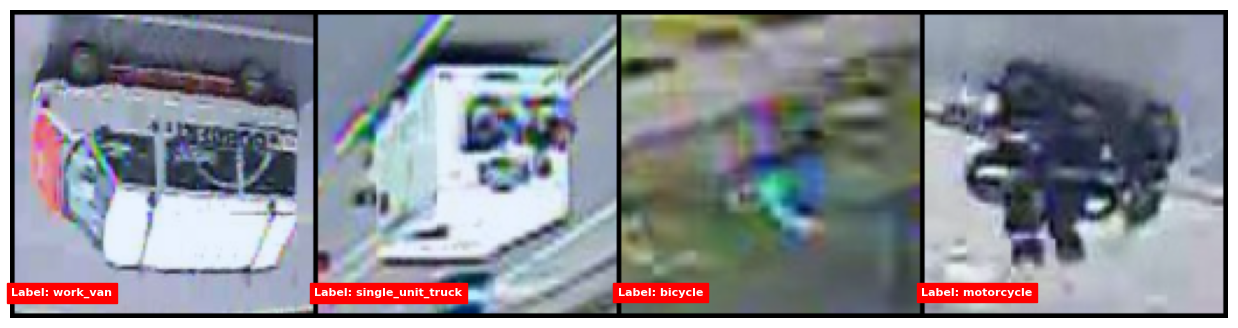

In [31]:
show_image_batch(classification_dataloader)

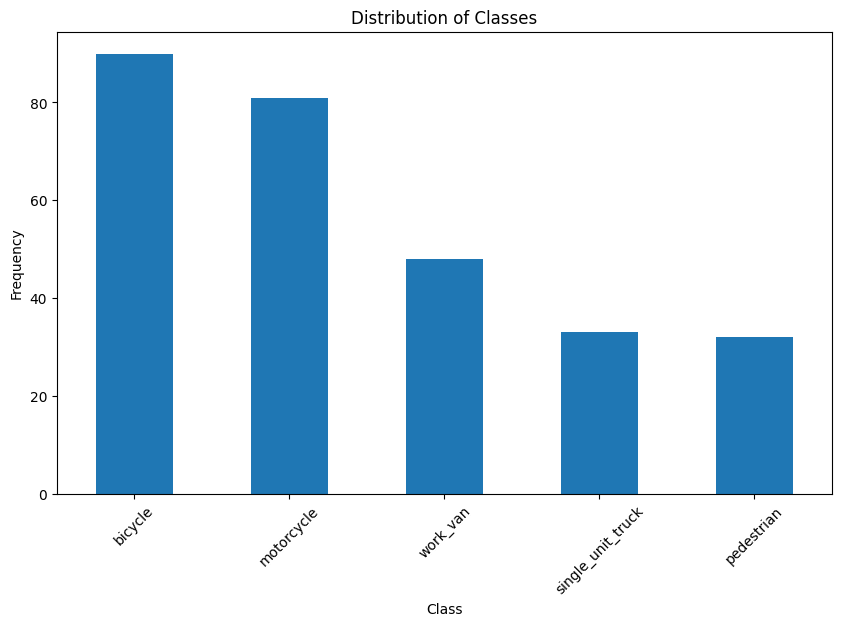

In [33]:
plot_class_distribution(classification_dataloader)